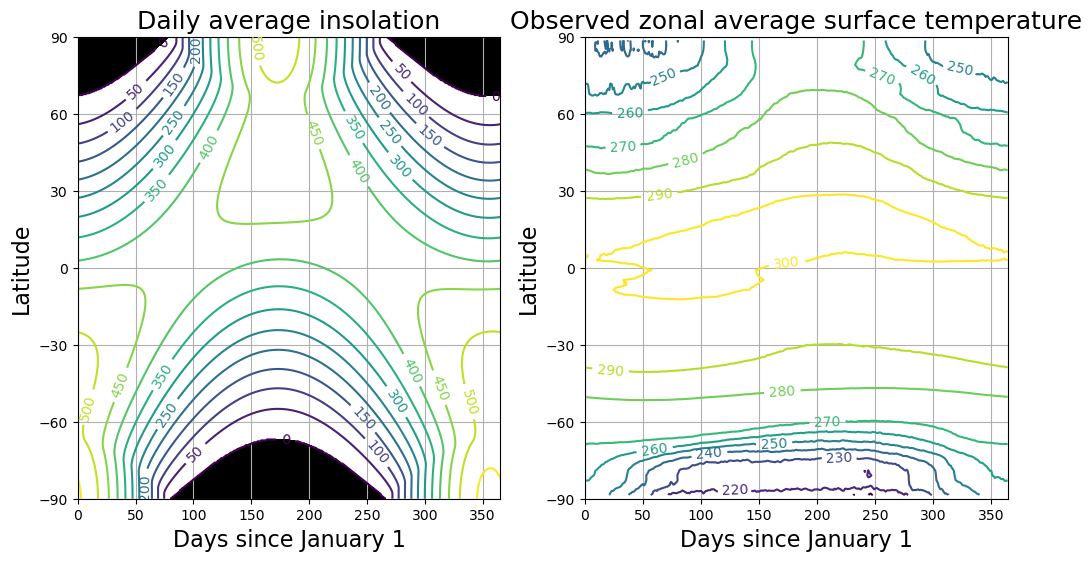

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const

#  Calculate daily average insolation as function of latitude and time of year
lat = np.linspace( -90., 90., 500 )
days = np.linspace(0, const.days_per_year, 365 )
Q = climlab.solar.insolation.daily_insolation( lat, days )

##  daily surface temperature from  NCEP reanalysis
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
ncep_temp = xr.open_dataset( ncep_url + "skt.sfc.day.1981-2010.ltm.nc", decode_times=False)
#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/'
#skt_path = 'surface_gauss/skt'
#ncep_temp = xr.open_dataset(url+skt_path)
ncep_temp_zon = ncep_temp.skt.mean(dim='lon')

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
CS = ax1.contour( days, lat, Q , levels = np.arange(0., 600., 50.) )
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=10)
ax1.set_title('Daily average insolation', fontsize=18 )
ax1.contourf ( days, lat, Q, levels=[-100., 0.], colors='k' )

ax2 = fig.add_subplot(122)
CS = ax2.contour( (ncep_temp.time - ncep_temp.time[0])/const.hours_per_day, ncep_temp.lat, 
                 ncep_temp_zon.T, levels=np.arange(210., 310., 10. ) )
ax2.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=10)
ax2.set_title('Observed zonal average surface temperature', fontsize=18 )

for ax in [ax1,ax2]:
    ax.set_xlabel('Days since January 1', fontsize=16 )
    ax.set_ylabel('Latitude', fontsize=16 )
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.grid()

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (40, 1) 
  Tatm: (40, 30) 
The subprocess tree: 
RCM: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   Fixed Relative Humidity: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>

Integrating for 81 steps, 81.0 days, or 0.22177064972229385 years.


Total elapsed time is 0.22177064972229385 years.
Integrating for 91 steps, 91.99999999999999 days, or 0.2518876515364325 years.


Total elapsed time is 0.4709203920028956 years.
Integrating for 94 steps, 94.00000000000001 days, or 0.2573634700480941 years.


Total elapsed time is 0.7282838620509897 years.
Integrating for 91 steps, 91.0 days, or 0.24914974228060174 years.


Total elapsed time is 0.9774336043315914 years.


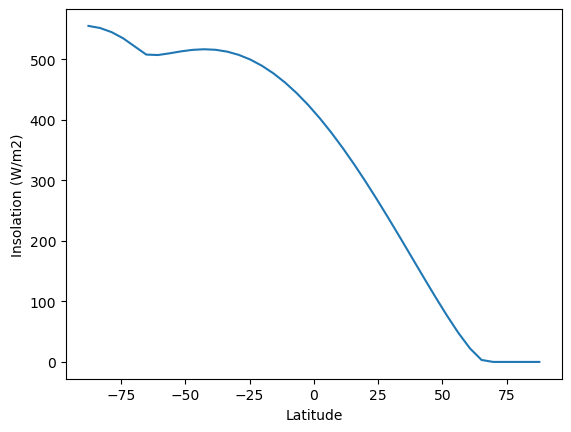

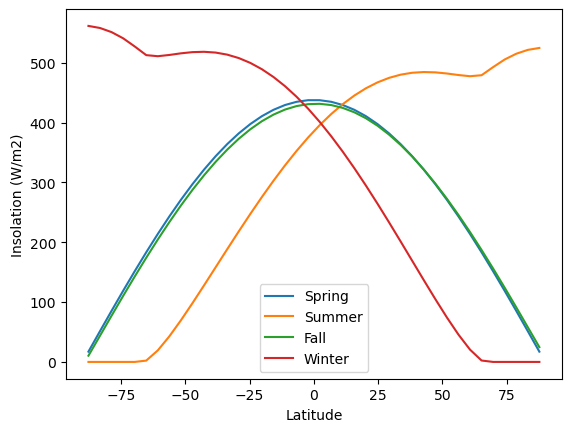

In [2]:
# A two-dimensional domain
state = climlab.column_state(num_lev=30, num_lat=40, water_depth=10.)
#  Specified relative humidity distribution
h2o = climlab.radiation.ManabeWaterVapor(name='Fixed Relative Humidity', state=state)
#  Hard convective adjustment
conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment', state=state, adj_lapse_rate=6.5)
#  Daily insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(name='Insolation', domains=state['Ts'].domain)
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                             state=state, 
                             specific_humidity=h2o.q, 
                             albedo=0.125,
                             coszen=sun.coszen,
                             irradiance_factor=sun.insolation)
model = climlab.couple([rad,sun,h2o,conv], name='RCM')
print( model)

model.compute_diagnostics()

fig, ax = plt.subplots()
ax.plot(model.lat, model.insolation)
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');

#climlab.radiation.DailyInsolation
#climlab.radiation.AnnualMeanInsolation

#  model is initialized on Jan. 1

#  integrate forward just under 1/4 year... should get about to the NH spring equinox
model.integrate_days(31+28+22)
Q_spring = model.insolation.copy()
#  Then forward to NH summer solstice
model.integrate_days(31+30+31)
Q_summer = model.insolation.copy()
#  and on to autumnal equinox
model.integrate_days(30+31+33)
Q_fall = model.insolation.copy()
#  and finally to NH winter solstice
model.integrate_days(30+31+30)
Q_winter = model.insolation.copy()

fig, ax = plt.subplots()
ax.plot(model.lat, Q_spring, label='Spring')
ax.plot(model.lat, Q_summer, label='Summer')
ax.plot(model.lat, Q_fall, label='Fall')
ax.plot(model.lat, Q_winter, label='Winter')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');


Integrating for 1460 steps, 1460.9688 days, or 4.0 years.


Total elapsed time is 4.974781117844542 years.


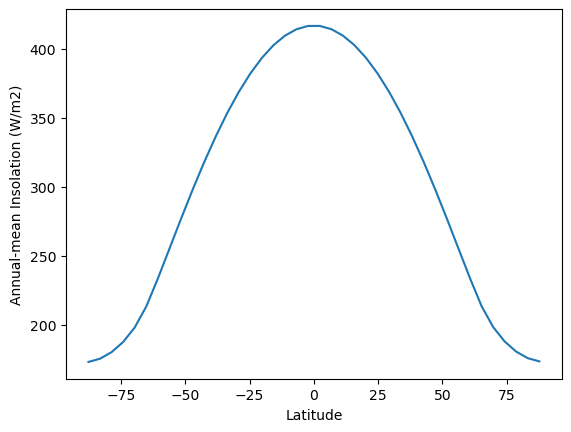

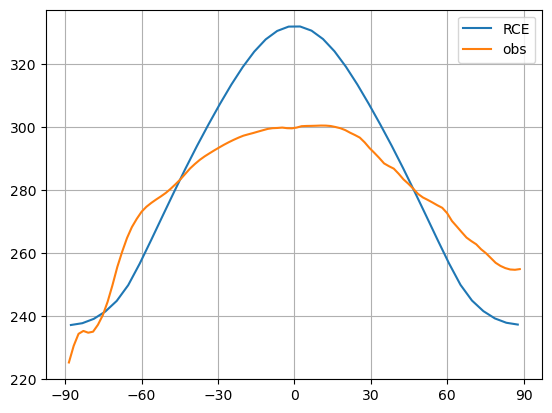

In [3]:
# time integration

model.integrate_years(4.)
#model.integrate_years(1.)

model.timeave.keys()

fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['insolation'])
ax.set_xlabel('Latitude')
ax.set_ylabel('Annual-mean Insolation (W/m2)')

# Plot annual mean surface temperature in the model,
#   compare to observed annual mean surface temperatures
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['Ts'], label='RCE')
ax.plot(ncep_temp_zon.lat, ncep_temp_zon.mean(dim='time'), label='obs')
ax.set_xticks(range(-90,100,30))
ax.grid(); ax.legend();


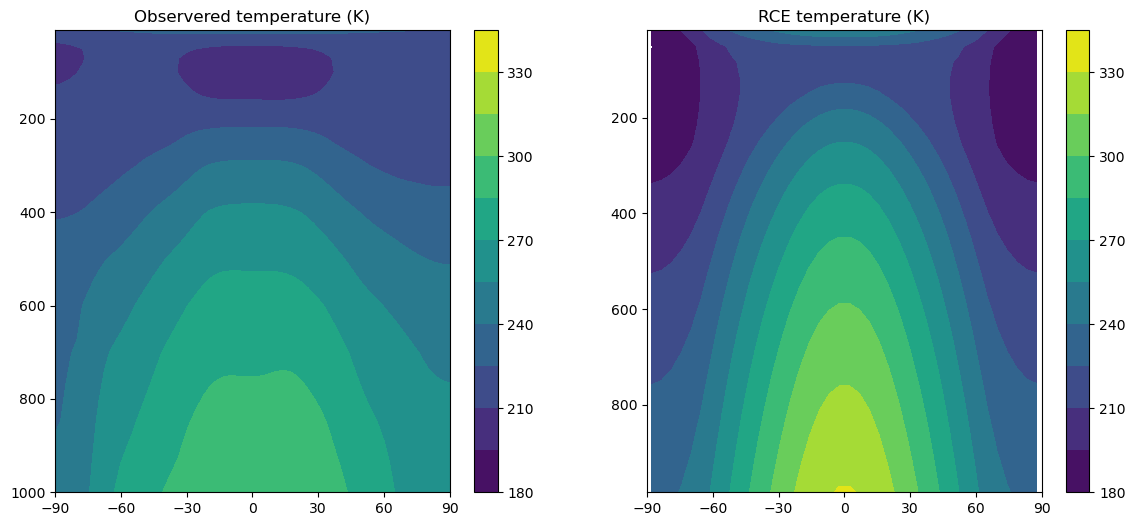

In [4]:
#  Observed air temperature from NCEP reanalysis
## The NOAA ESRL server is shutdown! January 2019
## may shutdown again in 2025
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
ncep_air = xr.open_dataset( ncep_url + "air.mon.1981-2010.ltm.nc", decode_times=False)
#air = xr.open_dataset(url+'pressure/air')
#ncep_air = air.rename({'lev':'level'})
level_ncep_air = ncep_air.level
lat_ncep_air = ncep_air.lat
Tzon = ncep_air.air.mean(dim=('time','lon'))

#  Compare temperature profiles in RCE and observations
contours = np.arange(180., 350., 15.)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
cax1 = ax1.contourf(lat_ncep_air, level_ncep_air, Tzon+const.tempCtoK, levels=contours)
fig.colorbar(cax1)
ax1.set_title('Observered temperature (K)')

ax2 = fig.add_subplot(1,2,2)
field = model.timeave['Tatm'].transpose()
cax2 = ax2.contourf(model.lat, model.lev, field, levels=contours)
fig.colorbar(cax2)
ax2.set_title('RCE temperature (K)')

for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])


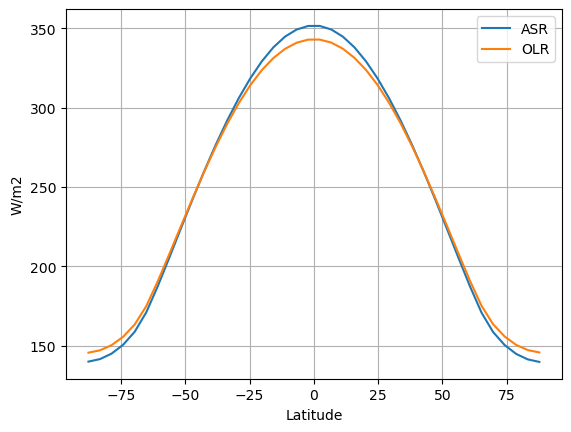

In [5]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['ASR'], label='ASR')
ax.plot(model.lat, model.timeave['OLR'], label='OLR')
ax.set_xlabel('Latitude')
ax.set_ylabel('W/m2')
ax.legend(); ax.grid()

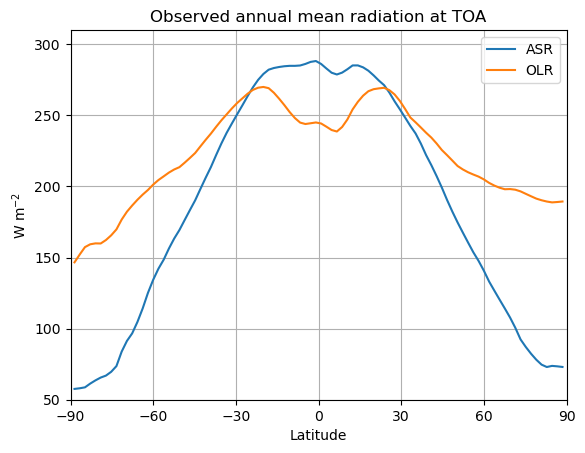

In [6]:
# Get TOA radiative flux data from NCEP reanalysis
# downwelling SW
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
dswrf = xr.open_dataset(ncep_url + 'dswrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#dswrf = xr.open_dataset(url + 'other_gauss/dswrf')
#  upwelling SW
uswrf = xr.open_dataset(ncep_url + 'uswrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#uswrf = xr.open_dataset(url + 'other_gauss/uswrf')
#  upwelling LW
ulwrf = xr.open_dataset(ncep_url + 'ulwrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#ulwrf = xr.open_dataset(url + 'other_gauss/ulwrf')

ASR = dswrf.dswrf - uswrf.uswrf
OLR = ulwrf.ulwrf

ASRzon = ASR.mean(dim=('time','lon'))
OLRzon = OLR.mean(dim=('time','lon'))

ticks = [-90, -60, -30, 0, 30, 60, 90]
fig, ax = plt.subplots()
ax.plot(ASRzon.lat, ASRzon, label='ASR')
ax.plot(OLRzon.lat, OLRzon, label='OLR')
ax.set_ylabel('W m$^{-2}$')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90); ax.set_ylim(50,310)
ax.set_xticks(ticks);
ax.set_title('Observed annual mean radiation at TOA')
ax.legend(); ax.grid();


Attempting to open the dataset  /Users/yuchiaol_ntuas/Desktop/ebooks/data/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  /Users/yuchiaol_ntuas/Desktop/ebooks/data/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  /Users/yuchiaol_ntuas/Desktop/ebooks/data/som_1850_f19.cam.h0.nc
Attempting to open the dataset  /Users/yuchiaol_ntuas/Desktop/ebooks/data/som_1850_2xCO2.cam.h0.nc


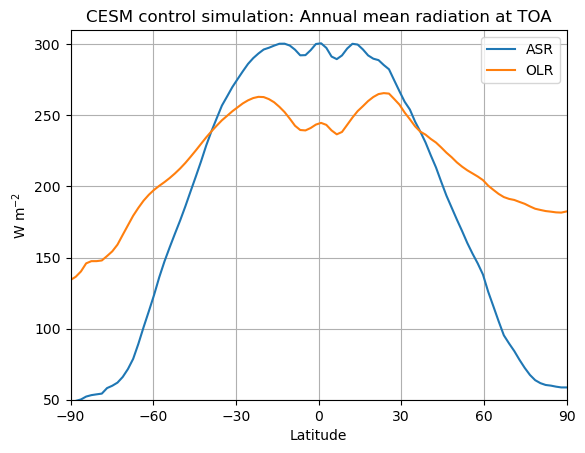

In [7]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
#basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
#basepath = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
#    casepaths[name] = basepath + casenames[name] + '/concatenated/'
    casepaths[name] = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"

# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path)

lat_cesm = atm['cpl_control'].lat
ASR_cesm = atm['cpl_control'].FSNT
OLR_cesm = atm['cpl_control'].FLNT

# extract the last 10 years from the slab ocean control simulation
# and the last 20 years from the coupled control
nyears_slab = 10
nyears_cpl = 20
clim_slice_slab = slice(-(nyears_slab*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

#  For now we're just working with the coupled control simulation
#  Take the time and zonal average
ASR_cesm_zon = ASR_cesm.isel(time=clim_slice_slab).mean(dim=('lon','time'))
OLR_cesm_zon = OLR_cesm.isel(time=clim_slice_slab).mean(dim=('lon','time'))

fig, ax = plt.subplots()
ax.plot(lat_cesm, ASR_cesm_zon, label='ASR')
ax.plot(lat_cesm, OLR_cesm_zon, label='OLR')
ax.set_ylabel('W m$^{-2}$')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90); ax.set_ylim(50,310)
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90]);
ax.set_title('CESM control simulation: Annual mean radiation at TOA')
ax.legend(); ax.grid();


Text(0.5, 1.0, 'Total northward heat transport inferred from CESM control simulation')

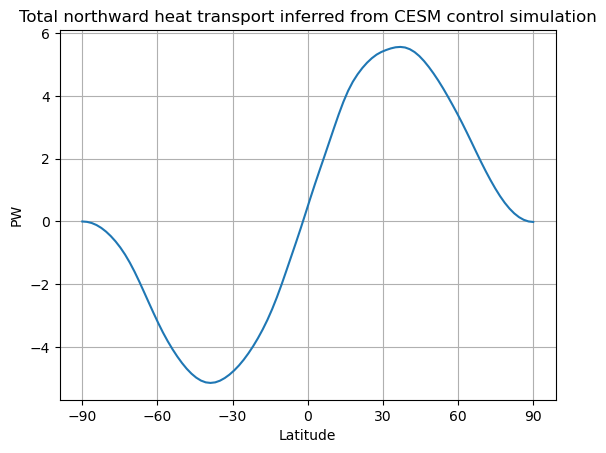

In [8]:
def inferred_heat_transport(energy_in, lat=None, latax=None):
    '''Compute heat transport as integral of local energy imbalance.
    Required input:
        energy_in: energy imbalance in W/m2, positive in to domain
    As either numpy array or xarray.DataArray
    If using plain numpy, need to supply these arguments:
        lat: latitude in degrees
        latax: axis number corresponding to latitude in the data
            (axis over which to integrate)
    returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''
    from scipy import integrate
    from climlab import constants as const
    if lat is None:
        try: lat = energy_in.lat
        except:
            raise InputError('Need to supply latitude array if input data is not self-describing.')
    lat_rad = np.deg2rad(lat)
    coslat = np.cos(lat_rad)
    field = coslat*energy_in
    if latax is None:
        try: latax = field.get_axis_num('lat')
        except:
            raise ValueError('Need to supply axis number for integral over latitude.')
    #  result as plain numpy array
    integral = integrate.cumulative_trapezoid(field, x=lat_rad, initial=0., axis=latax)
    result = (1E-15 * 2 * np.pi * const.a**2 * integral)
    if isinstance(field, xr.DataArray):
        result_xarray = field.copy()
        result_xarray.values = result
        return result_xarray
    else:
        return result

fig, ax = plt.subplots()
ax.plot(lat_cesm, inferred_heat_transport(ASR_cesm_zon - OLR_cesm_zon))
ax.set_ylabel('PW')
ax.set_xlabel('Latitude')
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax.grid()
ax.set_title('Total northward heat transport inferred from CESM control simulation')

Text(0.5, 1.0, 'Total northward heat transport inferred from NCEP reanalysis')

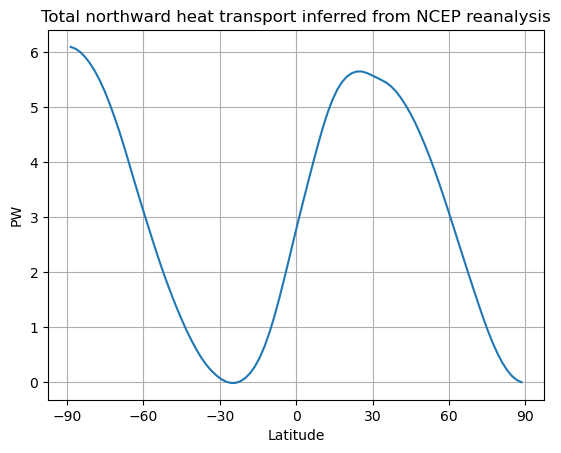

In [9]:
#  Need to flip the arrays because we want to start from the south pole
Rtoa_ncep = ASRzon-OLRzon
lat_ncep = ASRzon.lat
fig, ax = plt.subplots()
ax.plot(lat_ncep, inferred_heat_transport(Rtoa_ncep))
ax.set_ylabel('PW')
ax.set_xlabel('Latitude')
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax.grid()
ax.set_title('Total northward heat transport inferred from NCEP reanalysis')


The net downward TOA radiation flux in NCEP renalysis data is -12.0 W/m2.
The net downward TOA radiation flux after balancing the data is -1.66e-06 W/m2.


Text(0.5, 1.0, 'Total northward heat transport inferred from NCEP reanalysis (after global balancing)')

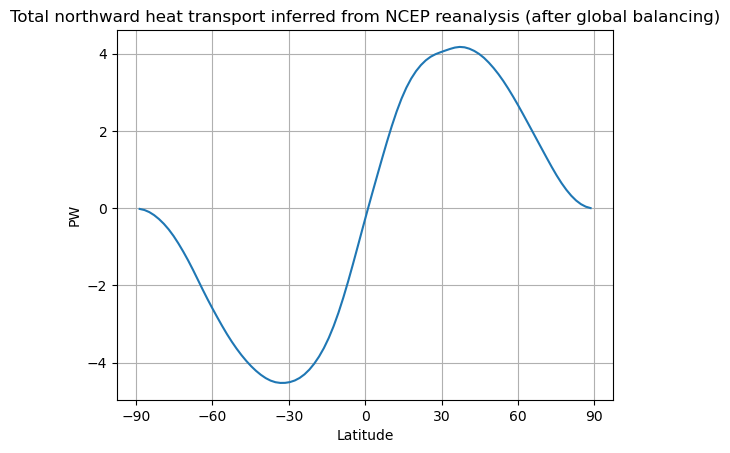

In [10]:
#  global average of TOA radiation in reanalysis data
weight_ncep = np.cos(np.deg2rad(lat_ncep)) / np.cos(np.deg2rad(lat_ncep)).mean(dim='lat')
imbal_ncep = (Rtoa_ncep).weighted(weight_ncep).mean(dim='lat')
print( 'The net downward TOA radiation flux in NCEP renalysis data is %0.1f W/m2.' %imbal_ncep)

Rtoa_ncep_balanced = Rtoa_ncep - imbal_ncep
newimbalance = float(Rtoa_ncep_balanced.weighted(weight_ncep).mean(dim='lat'))
print( 'The net downward TOA radiation flux after balancing the data is %0.2e W/m2.' %newimbalance)

fig, ax = plt.subplots()
ax.plot(lat_ncep, inferred_heat_transport(Rtoa_ncep_balanced))
ax.set_ylabel('PW')
ax.set_xlabel('Latitude')
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax.grid()
ax.set_title('Total northward heat transport inferred from NCEP reanalysis (after global balancing)')

Text(0.5, 1.0, 'Net upward surface energy flux in NCEP Reanalysis data')

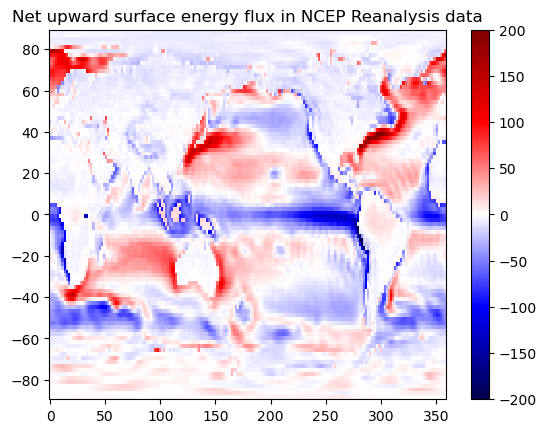

In [11]:
# monthly climatologies for surface flux data from reanalysis
#  all defined as positive UP
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
ncep_nswrs = xr.open_dataset(ncep_url + "nswrs.sfc.mon.1981-2010.ltm.nc", decode_times=False)
ncep_nlwrs = xr.open_dataset(ncep_url + "nlwrs.sfc.mon.1981-2010.ltm.nc", decode_times=False)
ncep_shtfl = xr.open_dataset(ncep_url + "shtfl.sfc.mon.1981-2010.ltm.nc", decode_times=False)
ncep_lhtfl = xr.open_dataset(ncep_url + "lhtfl.sfc.mon.1981-2010.ltm.nc", decode_times=False)

#  Calculate ANNUAL AVERAGE net upward surface flux
ncep_net_surface_up = (ncep_nlwrs.nlwrs
                     + ncep_nswrs.nswrs
                     + ncep_shtfl.shtfl
                     + ncep_lhtfl.lhtfl
                      ).mean(dim='time')

lon_ncep = ncep_net_surface_up.lon
fig, ax = plt.subplots()
cax = ax.pcolormesh(lon_ncep, lat_ncep, ncep_net_surface_up, 
               cmap=plt.cm.seismic, vmin=-200., vmax=200. )
fig.colorbar(cax, ax=ax)
ax.set_title('Net upward surface energy flux in NCEP Reanalysis data')


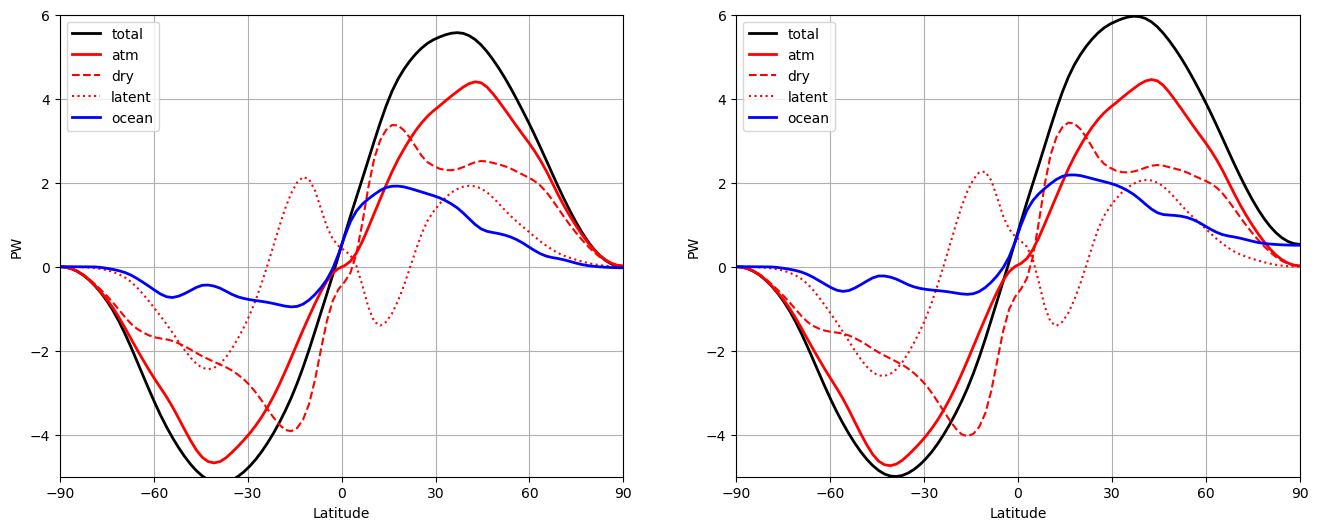

In [12]:
def CESM_heat_transport(run, timeslice=clim_slice_cpl):
    #  Take zonal and time averages of the necessary input fields
    fieldlist = ['FLNT','FSNT','LHFLX','SHFLX','FLNS','FSNS','PRECSC','PRECSL','QFLX','PRECC','PRECL']
    zon = run[fieldlist].isel(time=timeslice).mean(dim=('lon','time'))
    OLR = zon.FLNT
    ASR = zon.FSNT
    Rtoa = ASR - OLR  # net downwelling radiation
    #  surface energy budget terms, all defined as POSITIVE UP
    #    (from ocean to atmosphere)
    LHF = zon.LHFLX
    SHF = zon.SHFLX
    LWsfc = zon.FLNS
    SWsfc = -zon.FSNS
    SnowFlux =  ((zon.PRECSC + zon.PRECSL) *
                      const.rho_w * const.Lhfus)
    # net upward radiation from surface
    SurfaceRadiation = LWsfc + SWsfc
    # net upward surface heat flux
    SurfaceHeatFlux = SurfaceRadiation + LHF + SHF + SnowFlux
    # net heat flux into atmosphere
    Fatmin = Rtoa + SurfaceHeatFlux
    #  hydrological cycle, all terms in  kg/m2/s or mm/s
    Evap = zon.QFLX
    Precip = (zon.PRECC + zon.PRECL) * const.rho_w
    EminusP = Evap - Precip
        
    # heat transport terms
    HT = {}
    HT['total'] = inferred_heat_transport(Rtoa)
    HT['atm'] = inferred_heat_transport(Fatmin)
    HT['ocean'] = inferred_heat_transport(-SurfaceHeatFlux)
    HT['latent'] = inferred_heat_transport(EminusP*const.Lhvap) # atm. latent heat transport from moisture imbal.
    HT['dse'] = HT['atm'] - HT['latent']  # dry static energy transport as residual

    return HT

#  Compute heat transport partition for both control and 2xCO2 simulations
HT_control = CESM_heat_transport(atm['cpl_control'])
HT_2xCO2 = CESM_heat_transport(atm['cpl_CO2ramp'])

fig = plt.figure(figsize=(16,6))
runs = [HT_control, HT_2xCO2]
N = len(runs)

for n, HT in enumerate([HT_control, HT_2xCO2]):
    ax = fig.add_subplot(1, N, n+1)
    ax.plot(lat_cesm, HT['total'], 'k-', label='total', linewidth=2)
    ax.plot(lat_cesm, HT['atm'], 'r-', label='atm', linewidth=2)
    ax.plot(lat_cesm, HT['dse'], 'r--', label='dry')
    ax.plot(lat_cesm, HT['latent'], 'r:', label='latent')
    ax.plot(lat_cesm, HT['ocean'], 'b-', label='ocean', linewidth=2)

    ax.set_xlim(-90,90)
    ax.set_ylim(-5,6)
    ax.set_xticks(ticks)
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlabel('Latitude')
    ax.set_ylabel('PW')


climlab Process of type <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>. 
State variables and domain shapes: 
  default: (90, 1) 
The subprocess tree: 
Diffusion: <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>



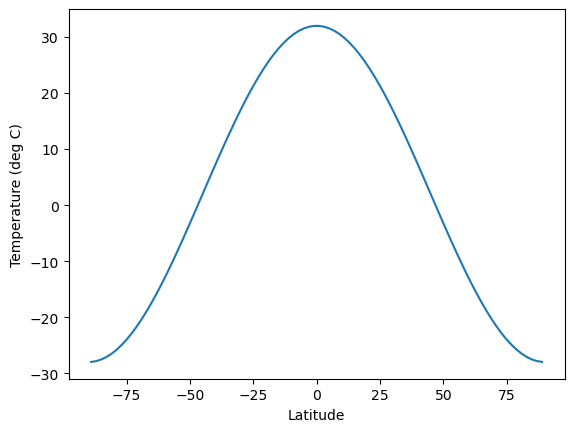

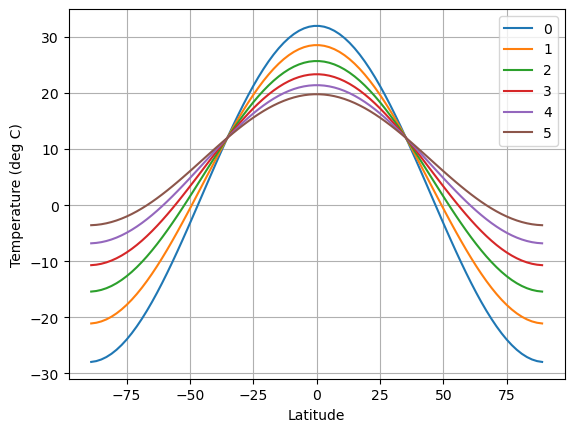

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

#  First define an initial temperature field
#   that is warm at the equator and cold at the poles
#   and varies smoothly with latitude in between

from climlab.utils import legendre
sfc = climlab.domain.zonal_mean_surface(num_lat=90, water_depth=10.)
lat = sfc.lat.points
initial = 12. - 40. * legendre.P2(np.sin(np.deg2rad(lat)))

fig, ax = plt.subplots()
ax.plot(lat, initial)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (deg C)');

##  Set up the climlab diffusion process

# make a copy of initial so that it remains unmodified
Ts = climlab.Field(np.array(initial), domain=sfc)
# thermal diffusivity in W/m**2/degC
D = 0.55
# create the climlab diffusion process
#  setting the diffusivity and a timestep of ONE MONTH
d = climlab.dynamics.MeridionalHeatDiffusion(name='Diffusion', 
            state=Ts, D=D, timestep=const.seconds_per_month)
print(d)

#  We are going to step forward one month at a time
#  and store the temperature each time
n_iter = 5
temp = np.zeros((Ts.size, n_iter+1))
temp[:, 0] = np.squeeze(Ts)
for n in range(n_iter):
    d.step_forward()
    temp[:, n+1] = np.squeeze(Ts)

#  Now plot the temperatures
fig,ax = plt.subplots()
ax.plot(lat, temp)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (deg C)')
ax.legend(range(n_iter+1)); ax.grid();


Text(0.5, 1.0, '$P_2(x)$')

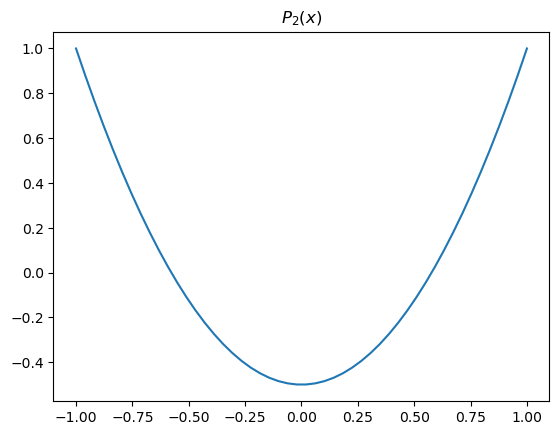

In [14]:
x = np.linspace(-1,1)
fig,ax = plt.subplots()
ax.plot(x, legendre.P2(x))
ax.set_title('$P_2(x)$')


<xarray.Dataset> Size: 2MB
Dimensions:             (lat: 94, lon: 192, time: 12, nbnds: 2)
Coordinates:
  * lat                 (lat) float32 376B 88.54 86.65 84.75 ... -86.65 -88.54
  * lon                 (lon) float32 768B 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * time                (time) float64 96B -6.571e+05 -6.57e+05 ... -6.567e+05
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) float64 192B ...
    skt                 (time, lat, lon) float32 866kB ...
    valid_yr_count      (time, lat, lon) float32 866kB ...
Attributes:
    title:                          4x daily NMC reanalysis
    description:                    Data is from NMC initialized reanalysis\n...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    dataset_title:             

Best fit is A = 214 W/m2 and B = 1.6 W/m2/degC


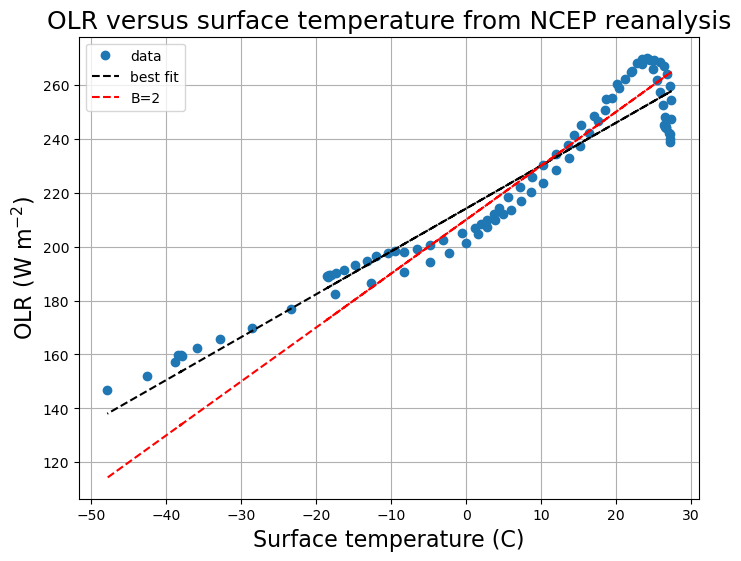

In [15]:
import xarray as xr
## The NOAA ESRL server is shutdown! January 2019
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = xr.open_dataset( ncep_url + "skt.sfc.mon.1981-2010.ltm.nc", decode_times=False)
#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/'
#ncep_Ts = xr.open_dataset(url + 'surface_gauss/skt')
lat_ncep = ncep_Ts.lat; lon_ncep = ncep_Ts.lon
print( ncep_Ts)

#  Take the annual and zonal average!
Ts_ncep_annual = ncep_Ts.skt.mean(dim=('lon','time'))

# TOA radiation data
ncep_ulwrf = xr.open_dataset( ncep_url + "ulwrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
ncep_dswrf = xr.open_dataset( ncep_url + "dswrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
ncep_uswrf = xr.open_dataset( ncep_url + "uswrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
OLR_ncep_annual = ncep_ulwrf.ulwrf.mean(dim=('lon','time'))
ASR_ncep_annual = (ncep_dswrf.dswrf - ncep_uswrf.uswrf).mean(dim=('lon','time'))

#  Use a linear regression package to compute best fit for the slope and intercept
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(Ts_ncep_annual, OLR_ncep_annual)

print( 'Best fit is A = %0.0f W/m2 and B = %0.1f W/m2/degC' %(intercept, slope))

#  More standard values
A = 210.
B = 2.

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot( Ts_ncep_annual, OLR_ncep_annual, 'o' , label='data')
ax1.plot( Ts_ncep_annual, intercept + slope * Ts_ncep_annual, 'k--', label='best fit')
ax1.plot( Ts_ncep_annual, A + B * Ts_ncep_annual, 'r--', label='B=2')
ax1.set_xlabel('Surface temperature (C)', fontsize=16)
ax1.set_ylabel('OLR (W m$^{-2}$)', fontsize=16)
ax1.set_title('OLR versus surface temperature from NCEP reanalysis', fontsize=18)
ax1.legend(loc='upper left')
ax1.grid()


The annual, global mean planetary albedo is 0.354


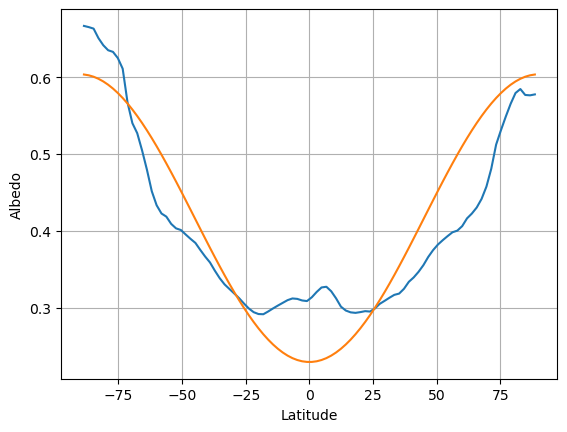

In [16]:
days = np.linspace(1.,50.)/50 * const.days_per_year
Qann_ncep = climlab.solar.insolation.daily_insolation(lat_ncep, days ).mean(dim='day')
albedo_ncep = 1 - ASR_ncep_annual / Qann_ncep

albedo_ncep_global = np.average(albedo_ncep, weights=np.cos(np.deg2rad(lat_ncep)))

print( 'The annual, global mean planetary albedo is %0.3f' %albedo_ncep_global)
fig,ax = plt.subplots()
ax.plot(lat_ncep, albedo_ncep)
ax.grid();
ax.set_xlabel('Latitude')
ax.set_ylabel('Albedo');

# Add a new curve to the previous figure
a0 = albedo_ncep_global
a2 = 0.25
ax.plot(lat_ncep, a0 + a2 * legendre.P2(np.sin(np.deg2rad(lat_ncep))))


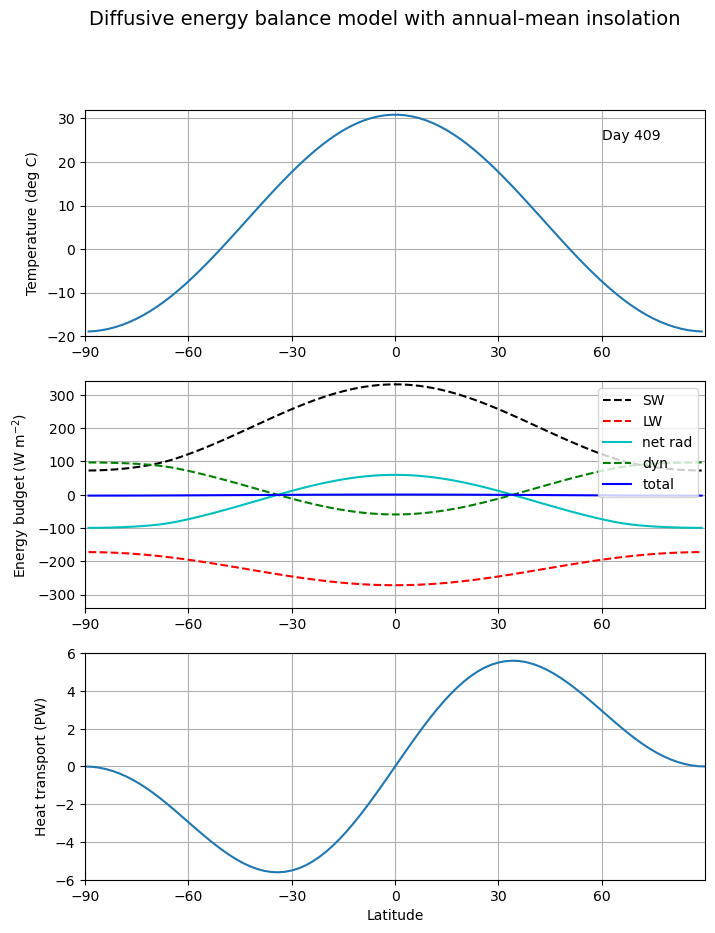

In [17]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

def setup_figure():
    templimits = -20,32
    radlimits = -340, 340
    htlimits = -6,6
    latlimits = -90,90
    lat_ticks = np.arange(-90,90,30)

    fig, axes = plt.subplots(3,1,figsize=(8,10))
    axes[0].set_ylabel('Temperature (deg C)')
    axes[0].set_ylim(templimits)
    axes[1].set_ylabel('Energy budget (W m$^{-2}$)')
    axes[1].set_ylim(radlimits)
    axes[2].set_ylabel('Heat transport (PW)')
    axes[2].set_ylim(htlimits)
    axes[2].set_xlabel('Latitude')
    for ax in axes: ax.set_xlim(latlimits); ax.set_xticks(lat_ticks); ax.grid()
    fig.suptitle('Diffusive energy balance model with annual-mean insolation', fontsize=14)
    return fig, axes

def initial_figure(model):
    #  Make figure and axes
    fig, axes = setup_figure()
    # plot initial data
    lines = []
    lines.append(axes[0].plot(model.lat, model.Ts)[0])
    lines.append(axes[1].plot(model.lat, model.ASR, 'k--', label='SW')[0])
    lines.append(axes[1].plot(model.lat, -model.OLR, 'r--', label='LW')[0])
    lines.append(axes[1].plot(model.lat, model.net_radiation, 'c-', label='net rad')[0])
    lines.append(axes[1].plot(model.lat, model.heat_transport_convergence, 'g--', label='dyn')[0])
    lines.append(axes[1].plot(model.lat, 
            model.net_radiation+model.heat_transport_convergence, 'b-', label='total')[0])
    axes[1].legend(loc='upper right')
    lines.append(axes[2].plot(model.lat_bounds, model.heat_transport)[0])
    lines.append(axes[0].text(60, 25, 'Day 0'))
    return fig, axes, lines

def animate(day, model, lines):
    model.step_forward()
    #  The rest of this is just updating the plot
    lines[0].set_ydata(model.Ts)
    lines[1].set_ydata(model.ASR)
    lines[2].set_ydata(-model.OLR)
    lines[3].set_ydata(model.net_radiation)
    lines[4].set_ydata(model.heat_transport_convergence)
    lines[5].set_ydata(model.net_radiation+model.heat_transport_convergence)
    lines[6].set_ydata(model.heat_transport)
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    return lines   

#  A model starting from isothermal initial conditions
e = climlab.EBM_annual()
e.Ts[:] = 15.  # in degrees Celsius
e.compute_diagnostics()

#  Plot initial data
fig, axes, lines = initial_figure(e)

ani = animation.FuncAnimation(fig, animate, frames=np.arange(1, 100), fargs=(e, lines))

HTML(ani.to_html5_video())


climlab Process of type <class 'climlab.model.ebm.EBM_annual'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
The subprocess tree: 
EBM: <class 'climlab.model.ebm.EBM_annual'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   albedo: <class 'climlab.surface.albedo.P2Albedo'>
   SW: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>
   diffusion: <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>

{'timestep': 350632.51200000005, 'S0': 1365.2, 's2': -0.48, 'A': 210, 'B': 2, 'D': 0.1, 'water_depth': 10.0, 'a0': 0.354, 'a2': 0.25}
Integrating for 900 steps, 3652.4220000000005 days, or 10 years.


Total elapsed time is 9.999999999999863 years.


Text(0.5, 0, 'Latitude')

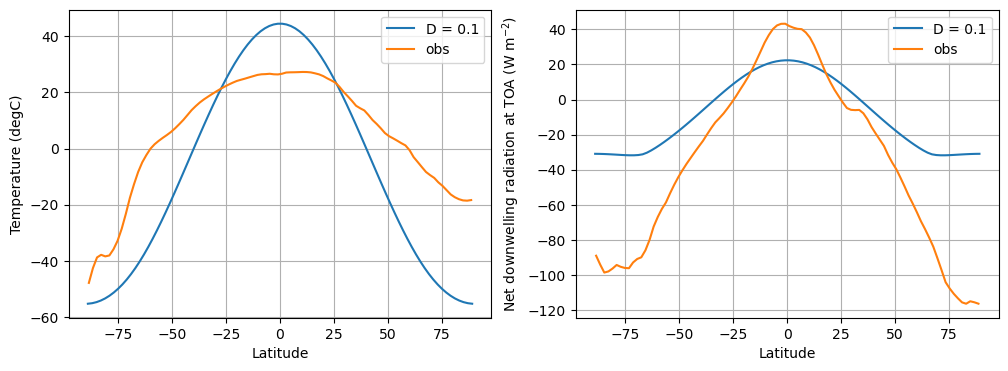

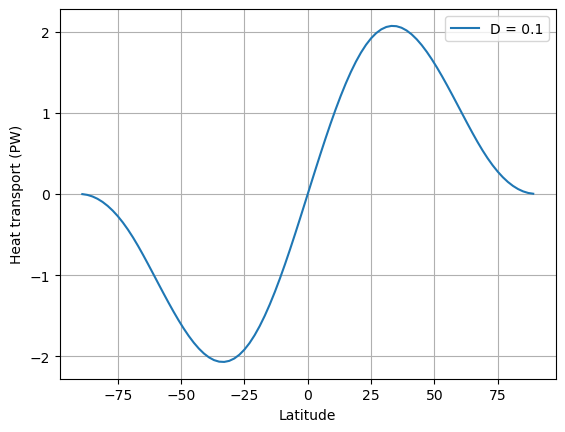

In [18]:
D = 0.1
model = climlab.EBM_annual(name='EBM', A=210, B=2, D=D, a0=0.354, a2=0.25)
print(model)

# The model object stores a dictionary of important parameters
print(model.param)

# Run it out long enough to reach equilibrium
model.integrate_years(10)

fig, axes = plt.subplots(1,2, figsize=(12,4))
ax = axes[0]
ax.plot(model.lat, model.Ts, label=('D = %0.1f' %D))
ax.plot(lat_ncep, Ts_ncep_annual, label='obs')
ax.set_ylabel('Temperature (degC)')
ax = axes[1]
energy_in = np.squeeze(model.ASR - model.OLR)
ax.plot(model.lat, energy_in, label=('D = %0.1f' %D))
ax.plot(lat_ncep, ASR_ncep_annual - OLR_ncep_annual, label='obs')
ax.set_ylabel('Net downwelling radiation at TOA (W m$^{-2}$)')
for ax in axes:
    ax.set_xlabel('Latitude'); ax.legend(); ax.grid();

def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.pi * const.a**2 * 
            integrate.cumulative_trapezoid( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

fig, ax = plt.subplots()
ax.plot(model.lat, inferred_heat_transport(energy_in, model.lat), label=('D = %0.1f' %D))
ax.set_ylabel('Heat transport (PW)')
ax.legend(); ax.grid()
ax.set_xlabel('Latitude')


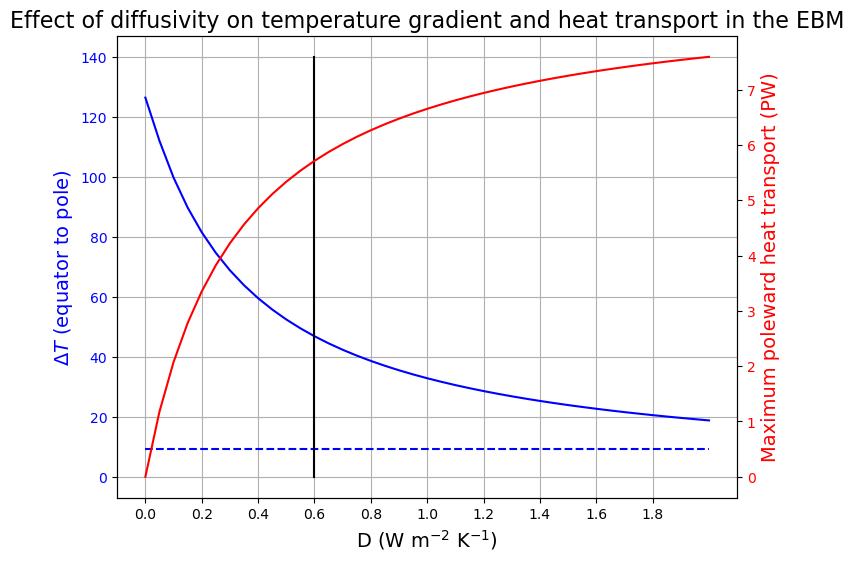

In [19]:
Darray = np.arange(0., 2.05, 0.05)

model_list = []
Tmean_list = []
deltaT_list = []
Hmax_list = []

for D in Darray:
    ebm = climlab.EBM_annual(A=210, B=2, a0=0.354, a2=0.25, D=D)
    ebm.integrate_years(20., verbose=False)
    Tmean = ebm.global_mean_temperature()
    deltaT = np.max(ebm.Ts) - np.min(ebm.Ts)
    energy_in = np.squeeze(ebm.ASR - ebm.OLR)
    Htrans = ebm.heat_transport
    Hmax = np.max(Htrans)
    model_list.append(ebm)
    Tmean_list.append(Tmean)
    deltaT_list.append(deltaT)
    Hmax_list.append(Hmax)

color1 = 'b'
color2 = 'r'

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(Darray, deltaT_list, color=color1)
ax1.plot(Darray, Tmean_list, 'b--')
ax1.set_xlabel(r'D (W m$^{-2}$ K$^{-1}$)', fontsize=14)
ax1.set_xticks(np.arange(Darray[0], Darray[-1], 0.2))
ax1.set_ylabel(r'$\Delta T$ (equator to pole)', fontsize=14,  color=color1)
for tl in ax1.get_yticklabels():
    tl.set_color(color1)
ax2 = ax1.twinx()
ax2.plot(Darray, Hmax_list, color=color2)
ax2.set_ylabel('Maximum poleward heat transport (PW)', fontsize=14, color=color2)
for tl in ax2.get_yticklabels():
    tl.set_color(color2)
ax1.set_title('Effect of diffusivity on temperature gradient and heat transport in the EBM', fontsize=16)
ax1.grid()

ax1.plot([0.6, 0.6], [0, 140], 'k-');
